In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time
import os
import tensorflow as tf

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # 占用GPU90%的显存 
session = tf.compat.v1.Session(config=config)

In [4]:
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True 
session = tf.compat.v1.Session(config=config)

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
import copy
x_tmp = copy.deepcopy(x_test[0])

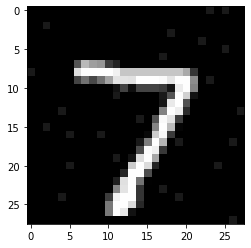

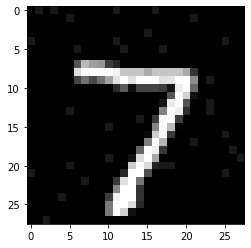

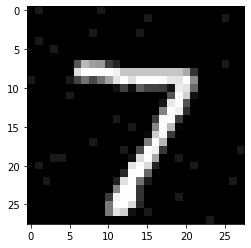

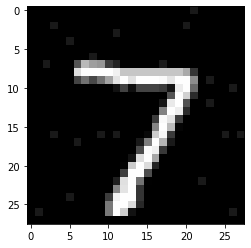

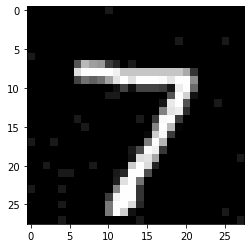

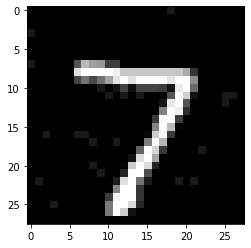

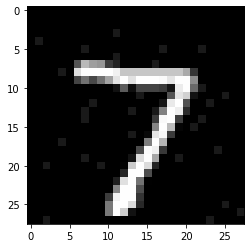

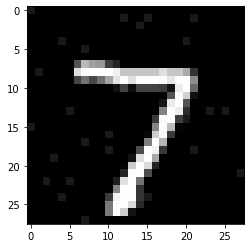

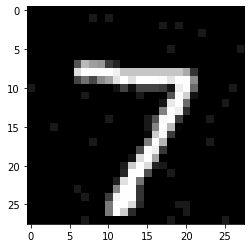

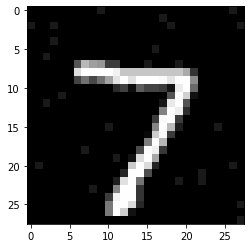

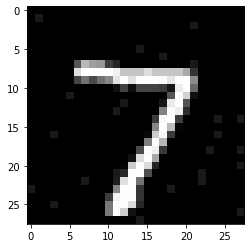

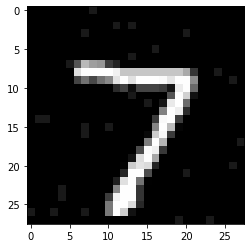

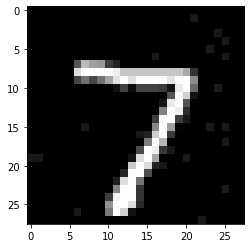

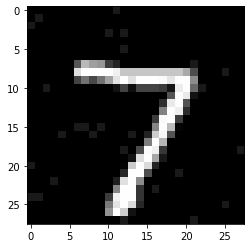

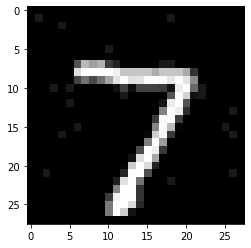

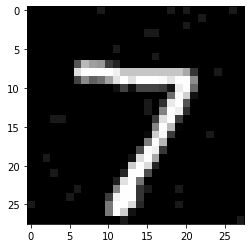

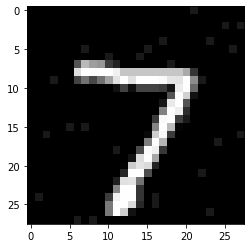

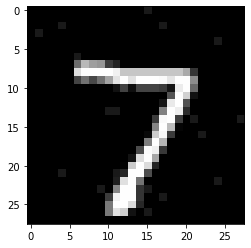

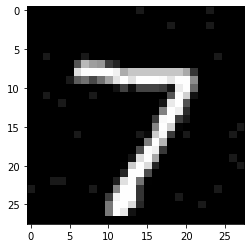

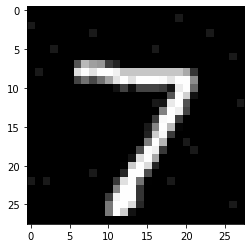

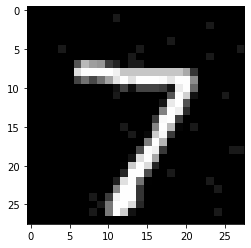

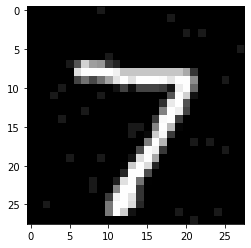

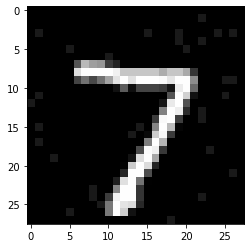

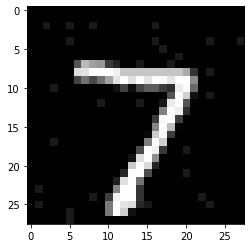

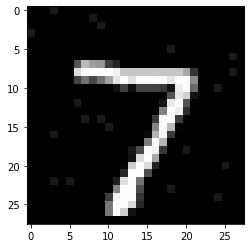

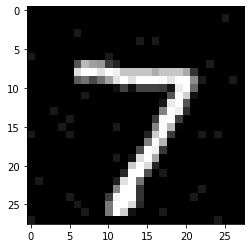

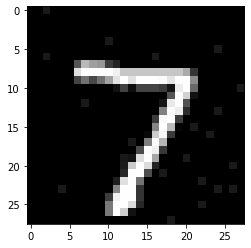

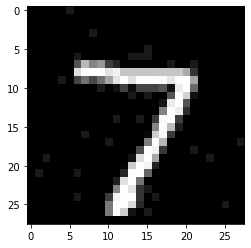

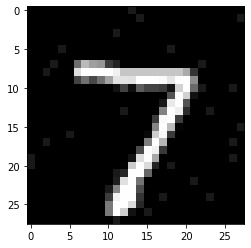

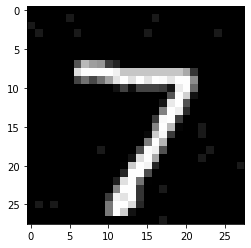

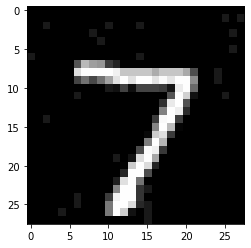

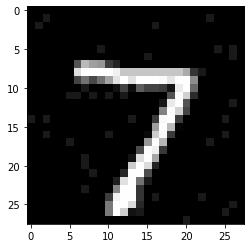

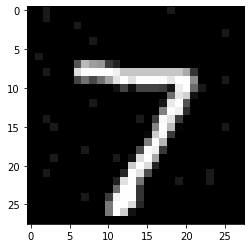

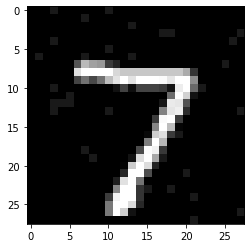

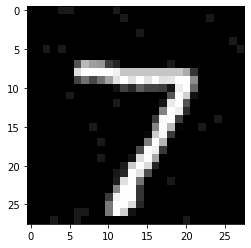

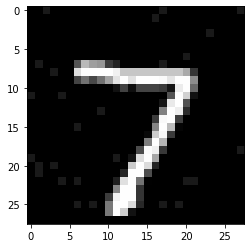

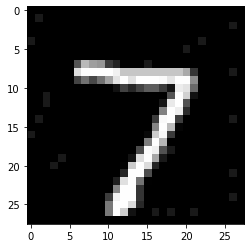

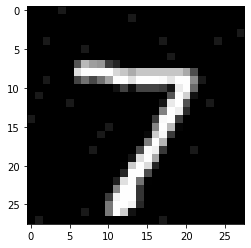

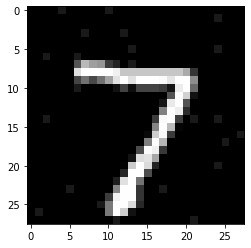

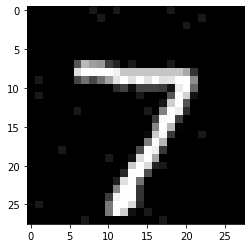

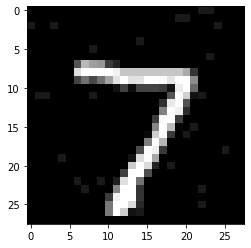

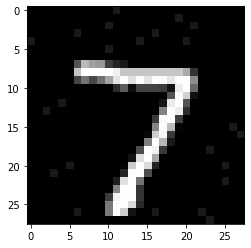

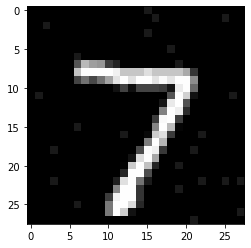

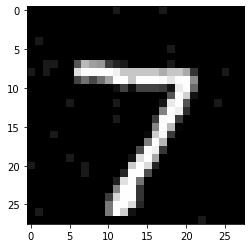

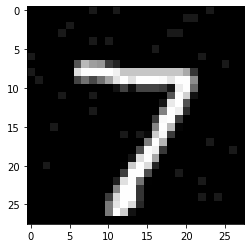

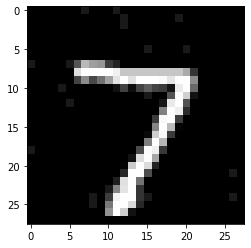

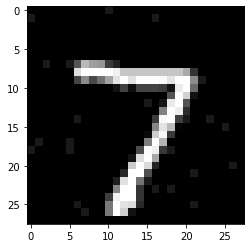

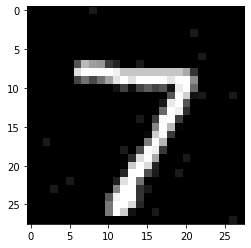

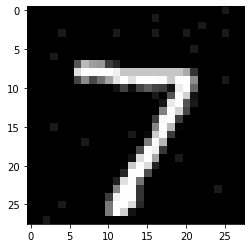

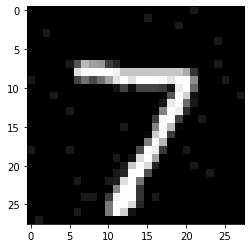

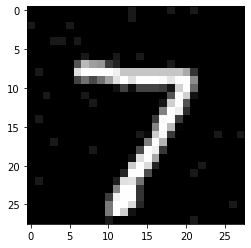

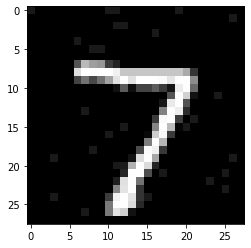

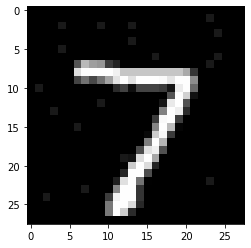

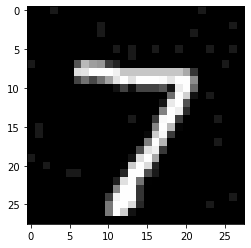

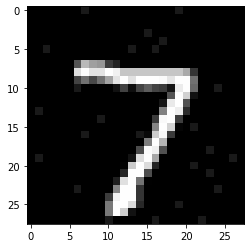

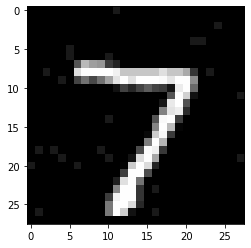

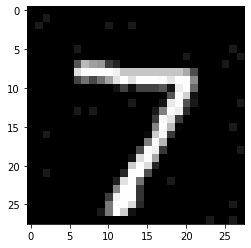

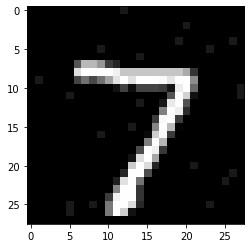

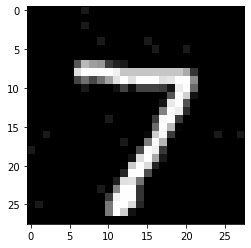

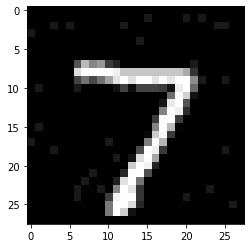

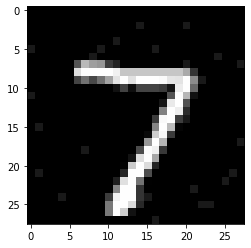

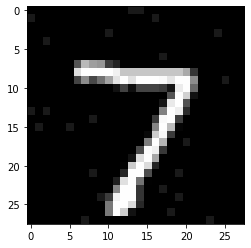

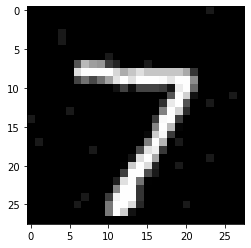

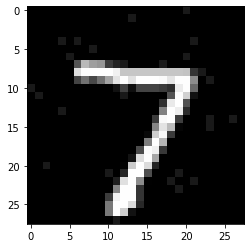

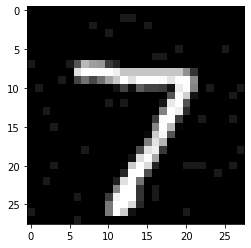

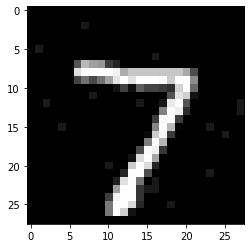

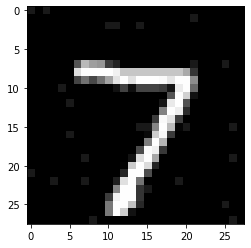

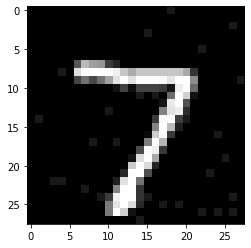

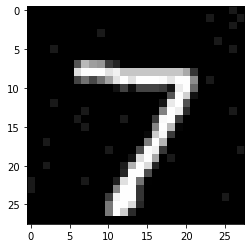

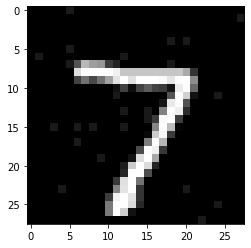

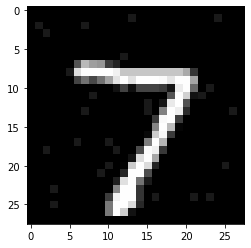

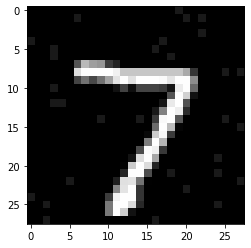

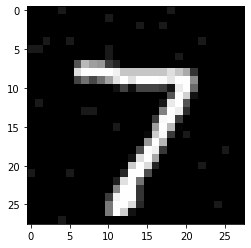

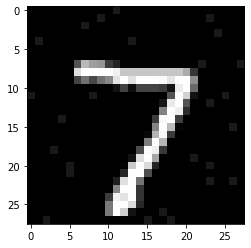

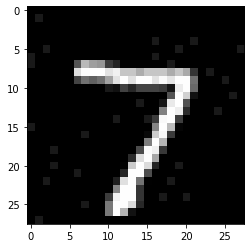

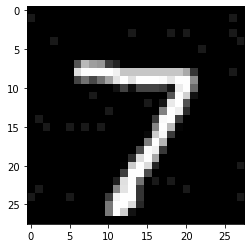

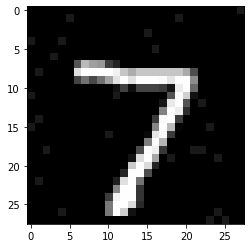

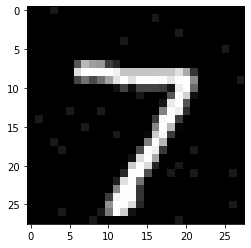

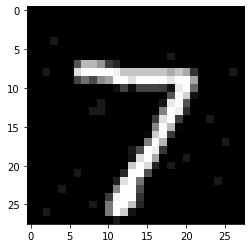

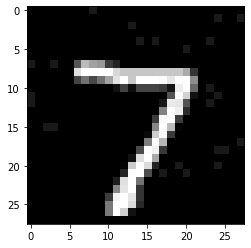

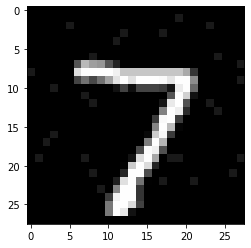

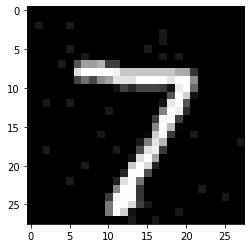

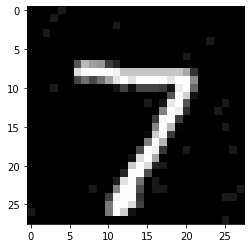

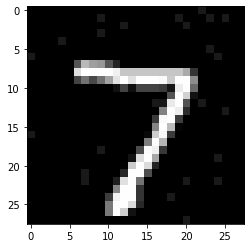

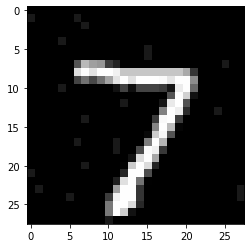

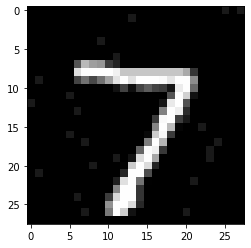

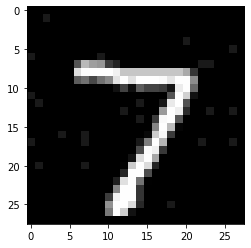

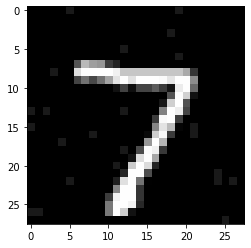

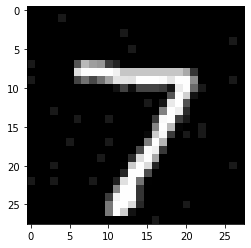

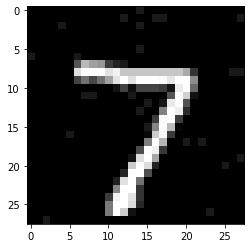

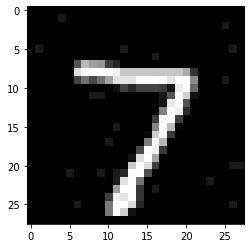

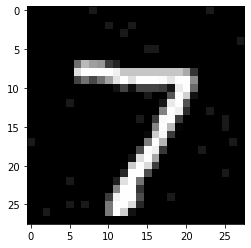

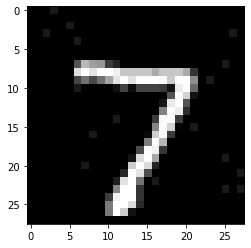

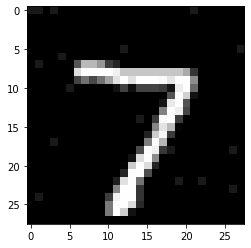

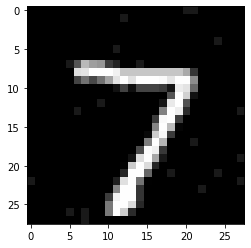

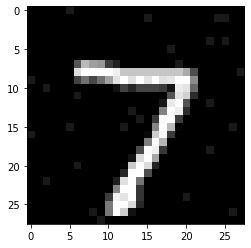

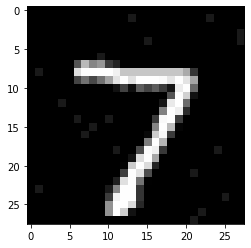

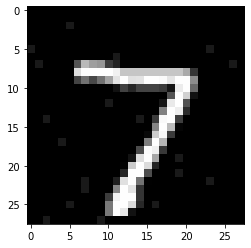

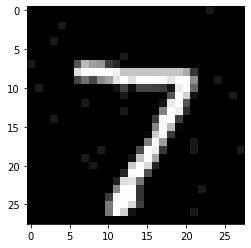

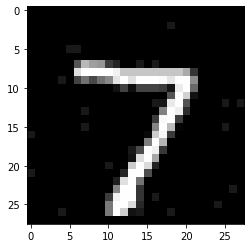

In [7]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [8]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [9]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [10]:
x_train = x_train / 255
x_test = x_test / 255 

In [11]:
model = load_model('mnist_model.h5')

In [12]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [13]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [14]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                best[:] = BEST_X[:]
            
            if Func(BEST_X) <= F:
                print("resume")
                if D < 7.5:
                    D += 0.4 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):     # 保存最好的数值
                best[:] = BEST_X[:]
            
            if Dis(BEST_X) <= D:
                print("attack")
                if F > 0.2:
                    F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [15]:
MAX_GENERATION = 100  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if Func(BEST_X) < 0.4:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.996774 扰动程度： 0.3635736955478665 代数： 1
最优值： 0.99667144 扰动程度： 0.34898187591619584 代数： 2
最优值： 0.9966383 扰动程度： 0.35338360602000213 代数： 3
最优值： 0.9966156 扰动程度： 0.3558386164298637 代数： 4
最优值： 0.9963242 扰动程度： 0.3526495924237123 代数： 5
最优值： 0.9963058 扰动程度： 0.35605224441065003 代数： 6
最优值： 0.99627244 扰动程度： 0.41726441359342215 代数： 7
最优值： 0.99602664 扰动程度： 0.3769475366501996 代数： 8
最优值： 0.99603516 扰动程度： 0.37701479530846893 代数： 9
最优值： 0.99600035 扰动程度： 0.37319523743487887 代数： 10
最优值： 0.9959921 扰动程度： 0.3937290747473958 代数： 11
最优值： 0.99587137 扰动程度： 0.3457260730831783 代数： 12


In [14]:
best

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  4.76038584e-03,  0.00000000e+00,
        0.00000000e+00,  6.82002557e-02,  0.00000000e+00,  7.12199673e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.49559834e-05,
        8.44994931e-02, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.64327948e-02,  0.00000000e+00,  6.21973893e-02,
        0.00000000e+00,  0.00000000e+00,  7.53864868e-04,  1.45964142e-03,
        2.26740228e-05,  0.00000000e+00,  1.80322107e-05, -0.00000000e+00,
        0.00000000e+00,  7.07831033e-03,  0.00000000e+00,  4.60572886e-03,
        1.21343986e-02,  5.30473886e-03,  5.36895272e-04,  1.35835728e-04,
        2.08333709e-01,  5.77508161e-03,  4.87748483e-03,  1.17956823e-04,
        6.14813901e-03,  1.05645019e-01,  0.00000000e+00,  1.29387617e-03,
        0.00000000e+00,  0.00000000e+00,  6.86631563e-03,  0.00000000e+00,
        7.75819100e-02,  

In [15]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.16744386 扰动程度： 7.837850060539154


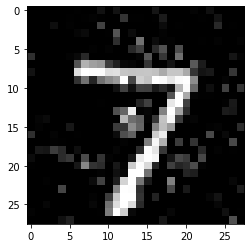

In [17]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [13]:
BEST_X

array([ 0.00000000e+00,  1.12291523e-02,  4.22988203e-02,  2.12128627e-06,
        8.56197183e-03,  1.33234895e-04,  0.00000000e+00,  1.67651070e-03,
        1.13954045e-03,  8.88149397e-02,  0.00000000e+00,  0.00000000e+00,
        2.05403298e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.11169477e-02,  6.92583745e-05,  5.46083869e-02,
        1.93278949e-01, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.35477324e-09,  0.00000000e+00,  3.72101798e-04,  1.86307333e-01,
        3.62133804e-03,  2.64553382e-04,  0.00000000e+00,  1.34234452e-06,
        0.00000000e+00,  0.00000000e+00,  7.61389463e-07,  0.00000000e+00,
        0.00000000e+00,  6.35557081e-02,  2.56904145e-05,  0.00000000e+00,
        3.88962725e-03, -0.00000000e+00,  1.26941265e-03,  5.61394451e-02,
        1.45497418e-02,  4.52919618e-03,  1.14664332e-03,  1.35964303e-04,
        2.62873627e-04,  1.64612472e-01,  0.00000000e+00,  9.34312856e-03,
        0.00000000e+00,  

最优值： 0.13100232 扰动程度： 9.958720184761686 代数： 981
最优值： 0.13034652 扰动程度： 10.019872028360068 代数： 982
最优值： 0.12675792 扰动程度： 10.038642353854181 代数： 983


In [10]:
BEST_X=np.array([ 2.98811370e-03,  0.00000000e+00,  2.96032449e-02, -0.00000000e+00,
        3.06530516e-04,  6.42609230e-03,  3.18746374e-01,  1.89771683e-02,
        0.00000000e+00,  2.64187821e-02,  6.43620050e-03,  0.00000000e+00,
        6.20448723e-03,  1.00481370e-02,  1.36315412e-02,  0.00000000e+00,
        3.61015051e-06,  0.00000000e+00,  4.16501156e-02,  0.00000000e+00,
        8.31291719e-02,  0.00000000e+00,  4.71880370e-02,  0.00000000e+00,
        6.44551883e-04,  6.67047446e-03,  8.75016178e-03,  1.43701179e-03,
        8.65358329e-02,  9.90600718e-06,  1.53562946e-02,  0.00000000e+00,
        0.00000000e+00,  6.66372503e-05,  0.00000000e+00,  0.00000000e+00,
        3.77465515e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.17021165e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.10336158e-02,  5.04285523e-03,  0.00000000e+00,
        5.05961939e-02,  6.32377466e-02,  0.00000000e+00,  8.45980433e-06,
        9.34816006e-02,  1.86434237e-04,  1.58898774e-02,  0.00000000e+00,
        2.75477514e-03,  1.42572336e-03,  5.08605321e-04,  2.52127616e-03,
        0.00000000e+00,  1.02229708e-01, -0.00000000e+00,  0.00000000e+00,
        6.75553438e-03,  1.69347882e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.17294084e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.28105016e-05,  1.88163598e-01,  0.00000000e+00,  5.07266450e-04,
        2.29652618e-04,  0.00000000e+00,  1.86875140e-02,  1.14148562e-02,
        3.90463126e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.24616369e-01,  6.03222878e-05,  1.56906695e-03,
        4.03522552e-04,  8.71161461e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.90364440e-03,
        4.66186435e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.15101249e-02,
        2.24743119e-04,  1.48193707e-02,  0.00000000e+00,  0.00000000e+00,
        2.37831110e-01,  2.79255166e-03,  1.39067028e-03,  0.00000000e+00,
        0.00000000e+00,  2.51148118e-02,  1.47752621e-02,  0.00000000e+00,
        1.60272418e-06,  1.50996777e-01,  0.00000000e+00,  2.75790034e-01,
        3.29335383e-01,  3.20708547e-01,  6.38219776e-02,  1.37152877e-05,
        5.38746360e-01,  9.16736881e-02,  2.99845973e-03,  2.68563179e-04,
        5.95421141e-04,  0.00000000e+00,  0.00000000e+00,  2.10694192e-03,
        0.00000000e+00,  3.91002065e-03,  0.00000000e+00,  0.00000000e+00,
        3.39644453e-05,  0.00000000e+00,  0.00000000e+00,  4.08804327e-07,
        2.53120990e-03,  2.89783568e-02,  0.00000000e+00,  2.56377072e-01,
        1.78093877e-01,  5.31741682e-02,  2.63007750e-03,  0.00000000e+00,
        1.63321608e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.29490137e-02,  9.67958329e-02,  2.14946705e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.05470537e-03,
        0.00000000e+00,  0.00000000e+00,  7.87865683e-02,  2.74577339e-02,
        1.28733963e-02,  6.63563992e-03,  1.09315626e-04,  0.00000000e+00,
        2.75923078e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.33370435e-03,  8.42627352e-05,  0.00000000e+00,  4.92077324e-03,
        2.50919708e-01,  8.76153565e-02,  2.41937107e-01,  5.47991750e-03,
        0.00000000e+00,  5.72300222e-05,  9.79888448e-03,  0.00000000e+00,
        1.35826750e-03,  4.62087598e-03, -0.00000000e+00,  2.50973732e-05,
        5.72100044e-02, -0.00000000e+00,  2.08098112e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.90971096e-02,  6.72208809e-03,
        8.62051364e-04,  8.06606702e-02, -1.00299364e-04, -1.57470888e-03,
       -1.23447078e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.22157375e-02,  0.00000000e+00,  0.00000000e+00,  2.45161346e-01,
        4.97712933e-05,  5.70408132e-03,  0.00000000e+00,  1.63170139e-02,
        2.48929985e-04,  3.89031482e-02,  2.11085862e-04,  1.45324170e-04,
        0.00000000e+00,  2.80453207e-02,  0.00000000e+00,  6.50526019e-03,
        5.93852954e-02,  2.49058702e-02,  2.96451075e-03,  6.97287437e-03,
        1.13056066e-03,  0.00000000e+00,  0.00000000e+00, -4.58136228e-02,
        3.35851820e-03, -5.03231993e-02, -7.65332468e-03, -6.20777710e-03,
       -3.16170384e-01, -4.71102133e-03, -1.22259990e-03, -2.72171447e-03,
       -8.61866084e-02, -1.52012094e-01, -4.14853019e-03,  6.20023783e-03,
       -1.74973580e-02, -4.37673730e-03,  8.32850987e-04,  1.06641411e-01,
        1.08305772e-03,  2.60936410e-04,  2.38584265e-02,  0.00000000e+00,
        3.45110124e-03,  1.34214733e-03,  0.00000000e+00,  1.48993963e-05,
        1.98346080e-02,  1.44318857e-04, -1.33739992e-04, -1.53276181e-02,
       -2.00673782e-01, -4.03340134e-03, -2.04373605e-01, -2.19249416e-01,
        0.00000000e+00,  0.00000000e+00, -1.07492344e-04,  0.00000000e+00,
       -9.74155100e-02, -3.00468266e-01, -1.94220356e-01,  3.30745701e-03,
        5.77267251e-04,  4.08250902e-03,  5.84975705e-05,  0.00000000e+00,
        1.19742429e-02,  2.14493261e-04,  7.75904510e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.29961006e-03,
        3.77785644e-03,  0.00000000e+00, -0.00000000e+00,  1.24112775e-04,
        5.98316606e-06,  4.07871111e-04,  0.00000000e+00, -2.02990033e-02,
       -1.85617397e-02,  0.00000000e+00,  0.00000000e+00, -1.39915670e-01,
       -3.33700430e-02,  3.05343948e-04, -2.35994785e-03, -1.05504494e-02,
        8.77509591e-04,  5.50455661e-03,  8.22759002e-06,  6.44174643e-05,
        0.00000000e+00,  3.59614892e-01, -0.00000000e+00,  2.12023832e-03,
        1.36182295e-08,  6.91104717e-04,  0.00000000e+00,  1.79117540e-03,
        5.03338756e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.88063490e-03,  5.68960588e-03,
        2.37902946e-03,  9.45800483e-04,  1.08865746e-02,  2.27263699e-03,
        2.46441520e-03,  1.25556716e-03, -6.38485751e-02,  2.25408295e-03,
       -1.70603584e-01,  4.55208920e-03,  0.00000000e+00,  4.42188420e-02,
        3.07372066e-02,  0.00000000e+00,  0.00000000e+00,  1.30545521e-03,
        7.80790096e-03,  1.46540995e-03,  4.37981652e-03, -0.00000000e+00,
        0.00000000e+00,  2.50235644e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.22885237e-03,
        1.28027429e-01,  1.93991956e-02,  1.56301703e-01,  6.31693022e-02,
        2.96865281e-05, -1.60466230e-02,  0.00000000e+00, -4.55661553e-04,
       -8.25007458e-04,  0.00000000e+00,  3.81690070e-03,  0.00000000e+00,
        0.00000000e+00,  8.49230561e-03,  1.04127906e-03,  1.55546329e-01,
        5.87544889e-05,  6.52585373e-03,  2.08614526e-01,  5.89694236e-02,
        1.34131289e-01,  4.67560976e-03,  2.48644213e-06,  0.00000000e+00,
        9.33906851e-04,  5.69318540e-04,  0.00000000e+00,  3.63109733e-01,
        7.60061330e-01,  6.92659152e-01,  4.18172914e-01,  0.00000000e+00,
        5.10210642e-05,  4.47860346e-03, -4.72890762e-06,  2.58345707e-05,
       -4.42593410e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.19735066e-05,  0.00000000e+00, -0.00000000e+00,  1.16329600e-04,
        0.00000000e+00,  1.48517441e-04,  4.69320884e-02,  5.99539119e-03,
        0.00000000e+00,  0.00000000e+00,  3.30397810e-05,  1.45661740e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.46029925e-01,
        2.60221521e-01,  9.94304709e-03,  2.46712981e-02,  1.53631004e-05,
       -1.19408852e-04,  3.97615835e-04, -2.08862176e-02, -1.95803762e-02,
        3.28936495e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.37730347e-02,  2.44793078e-03,  0.00000000e+00,  2.40907664e-04,
        2.16125474e-04,  0.00000000e+00,  9.60280158e-05,  0.00000000e+00,
        3.06790273e-08,  5.97540885e-04,  1.21227014e-04,  1.68011851e-03,
        1.57937102e-02,  6.07558062e-03,  7.09709818e-02,  0.00000000e+00,
        1.37913483e-05,  0.00000000e+00,  4.36417150e-01,  4.44943479e-05,
       -1.50942373e-03,  7.00474776e-04,  0.00000000e+00, -1.96078431e-02,
        0.00000000e+00,  4.82555207e-03,  7.28956135e-03,  0.00000000e+00,
        3.72112952e-04,  3.56057784e-02,  1.59928865e-07,  2.09289437e-01,
        1.61045257e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.90508259e-03,  7.63918541e-02,
        0.00000000e+00,  5.06719986e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.44775353e-02, -6.27069655e-02,  0.00000000e+00,
        2.10288414e-03,  1.28595390e-03,  1.12494579e-03,  1.79053060e-02,
        3.26598690e-04,  0.00000000e+00,  2.55029878e-02,  0.00000000e+00,
        1.81376304e-03,  7.52137611e-04,  1.76760401e-01,  1.47875216e-01,
        0.00000000e+00,  0.00000000e+00,  3.64319397e-03,  1.42370886e-03,
        0.00000000e+00,  0.00000000e+00,  5.51231073e-05,  5.79542077e-03,
        5.96899426e-06,  7.07865194e-03,  0.00000000e+00, -7.31350157e-02,
       -9.22688728e-03, -1.72833192e-02,  0.00000000e+00,  1.90930792e-04,
        0.00000000e+00,  6.64584026e-03,  0.00000000e+00,  0.00000000e+00,
        1.20895289e-04,  1.07351515e-01,  8.58180273e-04,  0.00000000e+00,
        4.61892996e-03,  4.69674956e-04,  0.00000000e+00,  0.00000000e+00,
        1.58118665e-01,  2.82972417e-01,  1.94746743e-01,  1.42022968e-01,
       -0.00000000e+00,  0.00000000e+00,  4.35920387e-03,  0.00000000e+00,
        9.53576661e-03,  6.19171022e-02,  1.20732309e-03,  5.53424782e-03,
       -3.89464427e-04,  0.00000000e+00,  1.17208329e-01,  6.09734216e-02,
        8.78250119e-04,  3.43464948e-01,  1.85681405e-01,  1.27006008e-07,
        3.78004780e-03,  3.59870864e-02,  0.00000000e+00,  5.45705904e-04,
        3.52154710e-04,  0.00000000e+00,  1.06374618e-02,  8.54264969e-05,
        0.00000000e+00,  1.93647680e-02,  3.87017631e-01,  2.85414590e-01,
        0.00000000e+00,  3.88507020e-01,  1.04752314e-01,  2.02487067e-04,
        0.00000000e+00,  4.93838058e-02,  3.82208957e-02, -7.25205963e-02,
        2.86848806e-01,  1.06071145e-02,  8.05460442e-02,  3.79437136e-01,
        2.12281753e-01,  1.99574051e-01,  4.79405304e-01,  1.31922351e-03,
        6.10587685e-04,  0.00000000e+00,  1.51266368e-03,  0.00000000e+00,
        4.90054268e-03,  2.93922598e-02,  0.00000000e+00,  4.72695169e-04,
        1.69360428e-02,  0.00000000e+00,  3.35345575e-01,  1.99232256e-01,
        1.08429761e-01,  2.50481579e-01,  2.11940395e-01,  0.00000000e+00,
        3.04399567e-02, -1.40890867e-02,  0.00000000e+00, -6.55473948e-05,
       -2.85593953e-04,  1.77554394e-04,  9.86316229e-02,  0.00000000e+00,
        7.97121182e-05,  3.31260620e-05,  0.00000000e+00,  2.06353103e-05,
        0.00000000e+00,  0.00000000e+00,  1.32676894e-02,  0.00000000e+00,
        1.56575321e-02,  0.00000000e+00,  0.00000000e+00,  1.75736788e-02,
        0.00000000e+00,  1.35186988e-02,  0.00000000e+00,  2.94679146e-03,
        1.71739993e-01,  2.63493603e-01,  2.54054839e-02,  0.00000000e+00,
        9.21504658e-04, -1.18238194e-03, -1.17402557e-01,  0.00000000e+00,
        3.83622453e-08,  0.00000000e+00,  4.02755197e-03,  5.50818668e-02,
        2.64895504e-01,  2.27483863e-02,  0.00000000e+00,  0.00000000e+00,
        6.26017772e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.13798302e-02,  0.00000000e+00,  1.66704580e-02,
        5.83090424e-03,  0.00000000e+00,  3.54520525e-02,  1.96694075e-01,
        1.72230374e-01,  1.32915773e-03,  2.01437478e-01,  2.28564282e-01,
        3.35750762e-02,  1.84056864e-04, -6.54444354e-02,  1.82123974e-03,
        3.68057502e-03,  5.95448204e-02,  9.37322260e-02,  3.71295150e-01,
        7.38146924e-02,  3.36652876e-01,  0.00000000e+00,  1.08501061e-05,
        0.00000000e+00,  5.63270113e-03,  6.15173700e-03,  1.34526915e-03,
        5.58834433e-03,  8.17596035e-03,  0.00000000e+00,  5.01830713e-03,
        2.93263489e-01,  0.00000000e+00,  1.65824521e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.61105693e-04, -6.74143207e-04,
       -2.47196931e-03,  2.03374833e-05, -8.47824021e-02,  1.63173552e-05,
        1.23904124e-02,  1.59336134e-06,  2.74275500e-01,  1.17521528e-02,
        1.15240196e-02,  3.05444384e-03,  0.00000000e+00,  6.38156684e-03,
        0.00000000e+00,  3.98164343e-02,  1.57302394e-03,  1.60022383e-03,
        0.00000000e+00,  0.00000000e+00,  1.34813114e-02,  0.00000000e+00,
        0.00000000e+00,  3.44896235e-05,  0.00000000e+00,  0.00000000e+00,
        1.63593096e-04,  9.03344265e-05,  1.54311824e-01, -5.97561095e-02,
       -7.22685938e-06,  0.00000000e+00,  1.89770913e-04,  2.05237050e-02,
        0.00000000e+00,  3.51749910e-04,  1.15560003e-02,  0.00000000e+00,
        9.20234372e-05,  0.00000000e+00,  0.00000000e+00,  4.83929844e-05,
        7.31156972e-03,  7.45381467e-04,  3.28991348e-03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.12616212e-02,  8.74425915e-03,
        3.16844550e-05,  0.00000000e+00,  0.00000000e+00,  5.20809070e-04,
        0.00000000e+00,  0.00000000e+00, -9.38451006e-03, -1.29273835e-02,
       -1.65884713e-01,  9.95947254e-05,  1.28134225e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.61713280e-04, -0.00000000e+00,
        0.00000000e+00,  5.40406741e-02,  0.00000000e+00,  0.00000000e+00,
        5.46063028e-03,  1.53739314e-02,  0.00000000e+00,  3.35924544e-03,
        0.00000000e+00,  6.05677739e-05,  2.16842708e-03,  3.41250353e-03,
        0.00000000e+00,  0.00000000e+00,  2.97435142e-02,  1.68249069e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.38449227e-02,
       -5.21959898e-05, -2.31468904e-02,  0.00000000e+00,  0.00000000e+00,
        5.40254759e-04, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.21554002e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.37694629e-01,  0.00000000e+00,  0.00000000e+00,
        1.82122309e-02,  9.23621013e-05,  5.90423432e-03,  1.09421432e-03,
        1.29115106e-01,  1.16387775e-01,  3.49655997e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.18940318e-04,  1.79455656e-01,
        7.45207254e-02,  3.09738418e-04,  1.60013815e-02,  0.00000000e+00,
        6.69385775e-05,  0.00000000e+00,  0.00000000e+00,  4.31482036e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.82737511e-02,  6.24068276e-02,  6.52179969e-03,  0.00000000e+00])

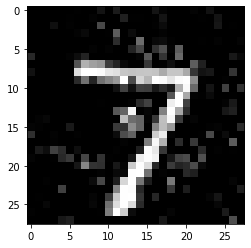

In [16]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [12]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

498


In [13]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

0


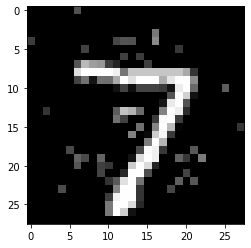

置信度： 0.79100835
[1.5174575e-03 6.5535348e-04 4.4565573e-02 1.5166000e-01 1.2409961e-04
 4.1875131e-03 1.3115628e-05 7.9100835e-01 2.5698482e-03 3.6986568e-03]
扰动程度： 5.808045297534583


In [23]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

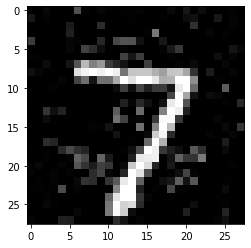

置信度： 0.7140484
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]
扰动程度： 5.399337470712778


In [21]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_F[i]) > 0.5:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.79081285


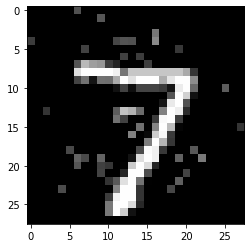

迭代: 2
置信度： 0.78750575


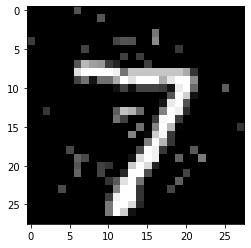

迭代: 3
置信度： 0.7869196


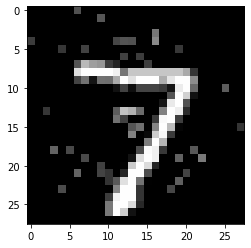

迭代: 4
置信度： 0.7822701


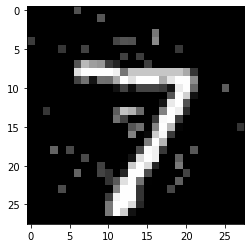

迭代: 5
置信度： 0.78187114


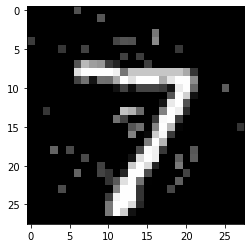

迭代: 6
置信度： 0.777245


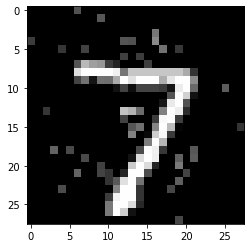

迭代: 7
置信度： 0.7769792


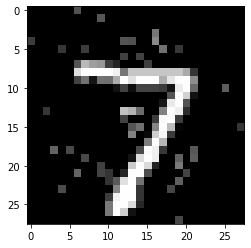

迭代: 8
置信度： 0.77427053


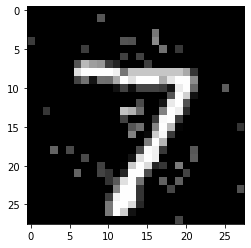

迭代: 9
置信度： 0.7742648


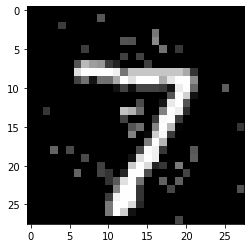

迭代: 10
置信度： 0.77287626


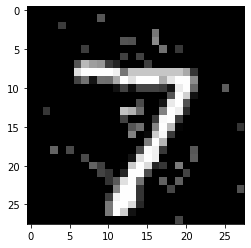

迭代: 11
置信度： 0.7688211


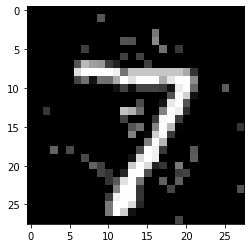

迭代: 12
置信度： 0.76710916


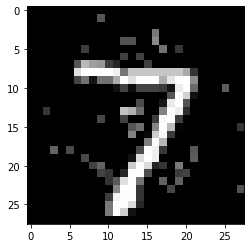

迭代: 13
置信度： 0.76175636


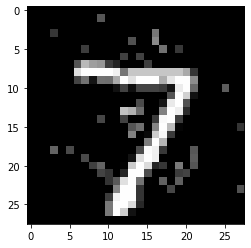

迭代: 14
置信度： 0.754947


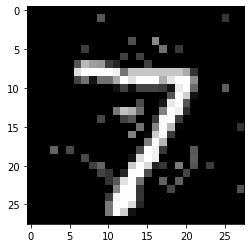

迭代: 15
置信度： 0.73712313


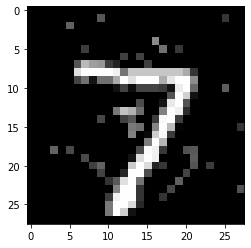

迭代: 16
置信度： 0.73679423


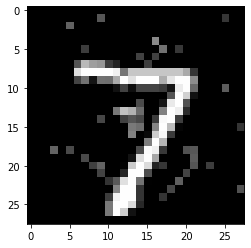

迭代: 17
置信度： 0.7302526


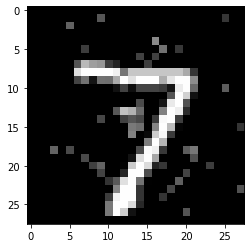

迭代: 18
置信度： 0.7288987


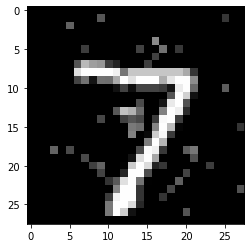

迭代: 19
置信度： 0.72669345


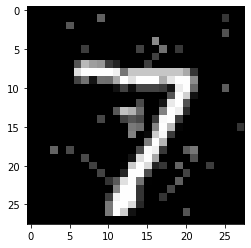

迭代: 20
置信度： 0.7041881


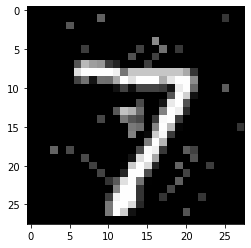

迭代: 21
置信度： 0.69990194


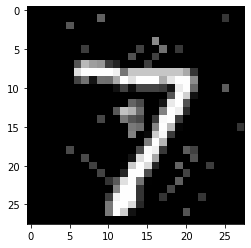

迭代: 22
置信度： 0.69171655


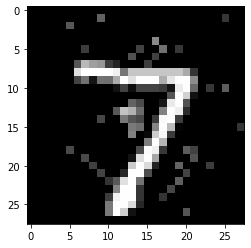

迭代: 23
置信度： 0.69031096


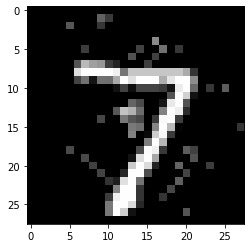

迭代: 24
置信度： 0.6852583


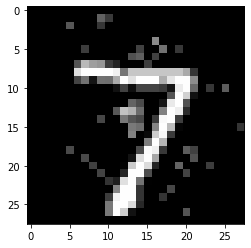

迭代: 25
置信度： 0.6840442


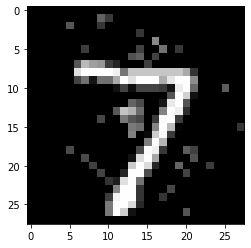

迭代: 26
置信度： 0.672793


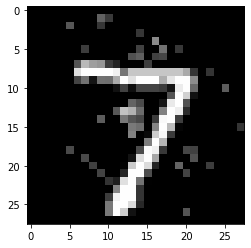

迭代: 27
置信度： 0.6632727


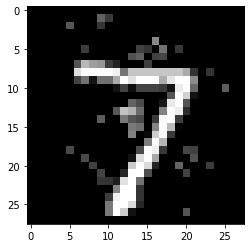

迭代: 28
置信度： 0.6593912


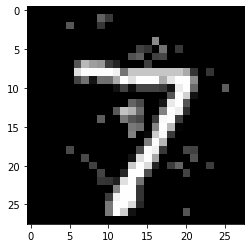

迭代: 29
置信度： 0.65689915


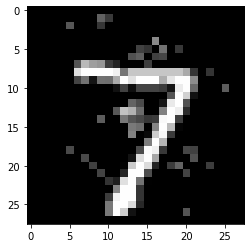

迭代: 30
置信度： 0.642851


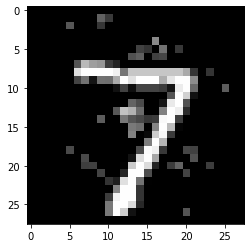

迭代: 31
置信度： 0.6423891


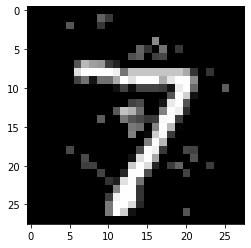

迭代: 32
置信度： 0.6416772


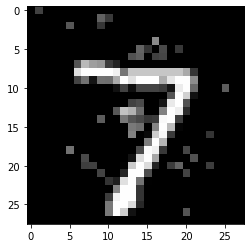

迭代: 33
置信度： 0.6382753


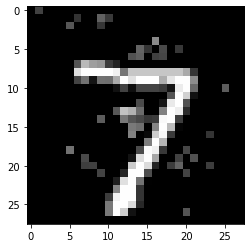

迭代: 34
置信度： 0.6347022


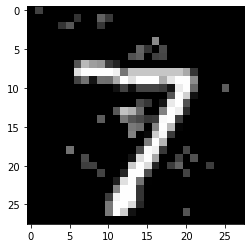

迭代: 35
置信度： 0.6346574


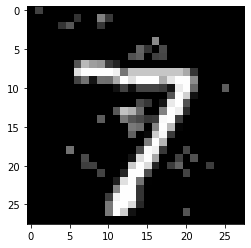

迭代: 36
置信度： 0.6339686


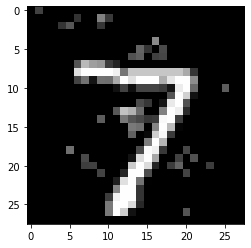

迭代: 37
置信度： 0.63303316


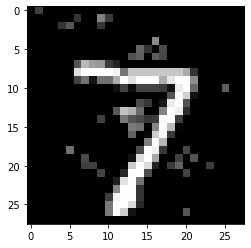

迭代: 38
置信度： 0.6291769


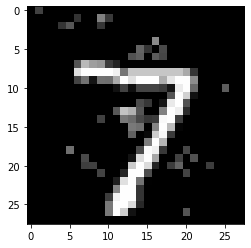

迭代: 39
置信度： 0.6288673


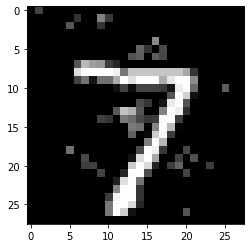

迭代: 40
置信度： 0.6225137


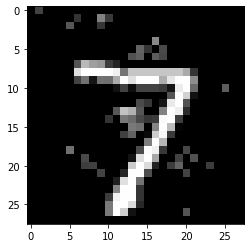

迭代: 41
置信度： 0.6176364


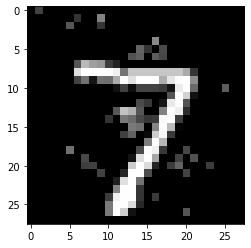

迭代: 42
置信度： 0.61705863


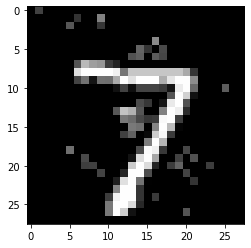

迭代: 43
置信度： 0.611814


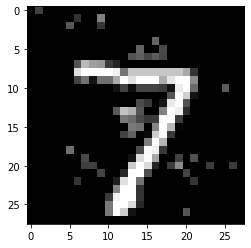

迭代: 44
置信度： 0.6064441


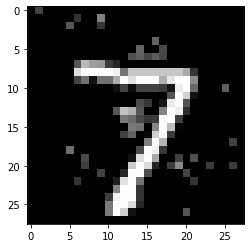

迭代: 45
置信度： 0.5942284


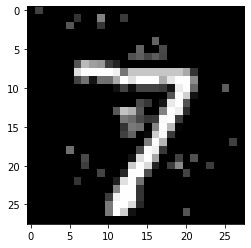

迭代失败


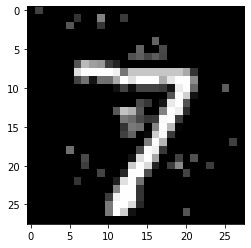

最终置信度： 0.5942284
最终扰动程度： 5.808045297534582
[1.0967220e-03 9.6672133e-04 4.5148227e-02 3.4004280e-01 1.6902824e-04
 4.2748246e-03 1.2764148e-05 5.9422839e-01 6.3656499e-03 7.6948670e-03]


In [24]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


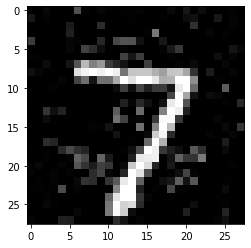

最终置信度： 0.7140484
最终扰动程度： 5.399337470712778
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]


In [22]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


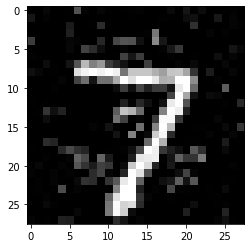

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])